# Learning pytorch with CNN and the CIFAR10 dataset

In [1]:
import os
import numpy as np
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
from torch.utils.data import Dataset
import cv2
from torch.utils import data
import matplotlib.pyplot as plt

## Initialize dataset class

In [11]:
# Create custom dataset class
# class SegNetDataset(Dataset):
# 	def __init__(self, root_dir, transform=None):
# 		self.root_dir = root_dir
# 		self.transform = transform
# 		# self.images = os.listdir(os.path.join(root_dir, 'color-input'))
# 		# self.masks = os.listdir(os.path.join(root_dir, 'label'))
# 		self.images = os.listdir(os.path.join(root_dir, 'color-input'))
# 		self.masks = os.listdir(os.path.join(root_dir, 'label'))


# 	def __len__(self):
# 		return len(self.images)

# 	def __getitem__(self, idx):
# 		img_path = os.path.join(self.root_dir, 'color-input', self.images[idx])
# 		mask_path = os.path.join(self.root_dir, 'label', self.masks[idx])
# 		image = cv2.imread(img_path)
# 		mask = cv2.imread(mask_path)
# 		if self.transform:
# 			image = self.transform(image)
# 			mask = self.transform(mask)
# 		return image, mask


transforms = tf.Compose([
	tf.ToTensor(),
	tf.Resize((500,500)),
	# tf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create custom dataset class for VOCSegmentation dataset from torchvision
class VOC(Dataset):
	def __init__(self, root_dir, transform=None, download=False):
		self.root_dir = root_dir
		self.transform = transform
		self.voc = torchvision.datasets.VOCSegmentation(root_dir, year='2012', image_set='train', download=download)
		self.images = self.voc.images
		self.masks = self.voc.masks

	def __len__(self):
		return len(self.images)

	def __getitem__(self, idx):
		image = self.images[idx]
		mask = self.masks[idx]

		image = cv2.imread(image)
		mask  = cv2.imread(mask)

		if self.transform:
			image = self.transform(image)
			mask = self.transform(mask)
		return image, mask

# Create dataset, train/test split and dataloaders
dataset = VOC(root_dir='data_voc', transform=transforms, download=False)
train_data, test_data = data.random_split(dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])

  0%|          | 0/1999639040 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Create dataloader for the dataset
train_loader = data.DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=4, shuffle=True)

# Load an image from the dataset using the dataloader
for images, masks in train_loader:
  print(type(images))

  plt.subplot(1, 2, 1)
  plt.imshow(images[0].permute(1,2,0))

  plt.subplot(1, 2, 2)
  plt.imshow(masks[0].permute(1,2,0))

  break

## Import necessary packages

In [12]:
from torch.nn import Conv2d, ReLU, BatchNorm2d, ConvTranspose2d, MaxPool2d, Module, Sequential, functional as F

## Define the encoder and decoder classes of U-Net

In [16]:
# Create UNET model
class UNet(Module):
    # Define encoder block
    def encoder_block(self, in_channels, out_channels):
        return Sequential(
            Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            ReLU(),
            BatchNorm2d(out_channels),
            Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            ReLU(),
            BatchNorm2d(out_channels)
        )

    # Define decoder block
    def decoder_block(self, in_channels, out_channels):
        return Sequential(
            ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            ReLU(),
            BatchNorm2d(out_channels),
            Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            ReLU(),
            BatchNorm2d(out_channels)
        )
    
    # Define bottleneck block
    def bottleneck(self, in_channels, out_channels):
        return Sequential(
            Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            ReLU(),
            BatchNorm2d(out_channels),
            Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            ReLU(),
            BatchNorm2d(out_channels),
            ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2),
            ReLU(),
            BatchNorm2d(out_channels)
        )

    # Define __init__()
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder1 = self.encoder_block(in_channels, 64)
        self.pool1 = MaxPool2d(2)
        self.encoder2 = self.encoder_block(64, 128)
        self.pool2 = MaxPool2d(2)
        self.encoder3 = self.encoder_block(128, 256)
        self.pool3 = MaxPool2d(2)
        self.encoder4 = self.encoder_block(256, 512)
        self.pool4 = MaxPool2d(2)
        self.bottleneck = self.bottleneck(512, 1024)
        self.decoder4 = self.decoder_block(1024, 512)
        self.decoder3 = self.decoder_block(512, 256)
        self.decoder2 = self.decoder_block(256, 128)
        self.decoder1 = self.decoder_block(128, 64)
        self.conv = Conv2d(64, out_channels, kernel_size=1)

    # Determine crop size and concatenate for skip connections
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.shape[2] - upsampled.shape[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)

    # Define forward pass
    def forward(self, x):
        encoder1 = self.encoder1(x)
        pool1 = self.pool1(encoder1)
        encoder2 = self.encoder2(pool1)
        pool2 = self.pool2(encoder2)
        encoder3 = self.encoder3(pool2)
        pool3 = self.pool3(encoder3)
        encoder4 = self.encoder4(pool3)
        pool4 = self.pool4(encoder4)
        bottleneck = self.bottleneck(pool4)
        decoder4 = self.crop_and_concat(bottleneck, encoder4, crop=True)
        decoder4 = self.decoder4(decoder4)
        decoder3 = self.crop_and_concat(decoder4, encoder3, crop=True)
        decoder3 = self.decoder3(decoder3)
        decoder2 = self.crop_and_concat(decoder3, encoder2, crop=True)
        decoder2 = self.decoder2(decoder2)
        decoder1 = self.crop_and_concat(decoder2, encoder1, crop=True)
        decoder1 = self.decoder1(decoder1)
        return self.conv(decoder1)
 

In [ ]:
# Create UNET model
class UNet(Module):
    def encode_block(self, in_channels, out_channels, kernel_size=3):
        enc_block = Sequential(            
            Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            ReLU(),
            BatchNorm2d(out_channels),
            Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            ReLU(),
            BatchNorm2d(out_channels)
        )
        return enc_block

    def bottle_neck(self, in_channels, out_channels, kernel_size=3):
        bottle_neck_block = Sequential(
            Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            ReLU(),
            BatchNorm2d(out_channels),
            Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            ReLU(),
            BatchNorm2d(out_channels),
            ConvTranspose2d(in_channels=out_channels, out_channels=in_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1)
        )
        return bottle_neck_block

    def decode_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        dec_block = Sequential(
            Conv2d(in_channels=in_channels, out_channels=mid_channel, kernel_size=kernel_size),
            ReLU(),
            BatchNorm2d(mid_channel),
            Conv2d(in_channels=mid_channel, out_channels=mid_channel, kernel_size=kernel_size),
            ReLU(),
            BatchNorm2d(mid_channel),
            ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1)
        )
        return dec_block


    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(UNet, self).__init__()
        # Encode
        self.encode_block1 = self.encode_block(in_channels, 64, kernel_size)
        self.conv_maxpool1 = MaxPool2d(kernel_size=2)
        self.encode_block2 = self.encode_block(64, 128, kernel_size)
        self.conv_maxpool2 = MaxPool2d(kernel_size=2)
        self.encode_block3 = self.encode_block(128, 256, kernel_size)
        self.conv_maxpool3 = MaxPool2d(kernel_size=2)
        self.encode_block4 = self.encode_block(256, 512, kernel_size)
        self.conv_maxpool4 = MaxPool2d(kernel_size=2)

        # Bottle Neck
        self.bottle_neck1  = self.bottle_neck(512, 1024, kernel_size)

        # Decode
        self.decode_block4 = self.decode_block(1024, 512, 256, kernel_size)
        self.decode_block3 = self.decode_block(512, 256, 128, kernel_size)
        self.decode_block2 = self.decode_block(256, 128, 64, kernel_size)
        self.decode_block1 = self.decode_block(128, 64, out_channels, kernel_size)

    
    # Define skip connection function to handle batch size
    def skip_connection(self, x, skip):
        x = torch.cat((x, skip), dim=1)
        return x

    def skip_and_crop_connection(self, x, skip, crop=False):
        if crop:
            x = x[:, :, :skip.shape[2], :skip.shape[3]]
        return torch.cat([x, skip], dim=1)
    
    def skip_connection_crop(self, x, skip):
        # Print
        # print("x: ", x.shape)
        # print("skip: ", skip.shape)
        if x.shape != skip.shape:
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x, skip), dim=1)
        return x


    # Forward Pass
    def forward(self, x):
        # Encode
        skip1 = self.encode_block1(x)
        x     = self.conv_maxpool1(skip1)

        # Print
        # print("Encode Block 1: ", skip1.shape)
        # print("Max Pool 1: ", x.shape)

        skip2 = self.encode_block2(x)
        x     = self.conv_maxpool2(skip2)

        # Print
        # print("Encode Block 2: ", skip2.shape)
        # print("Max Pool 2: ", x.shape)

        skip3 = self.encode_block3(x)
        x     = self.conv_maxpool3(skip3)

        # Print
        # print("Encode Block 3: ", skip3.shape)
        # print("Max Pool 3: ", x.shape)


        skip4 = self.encode_block4(x)
        x     = self.conv_maxpool4(skip4)

        # Print
        # print("Encode Block 4: ", skip4.shape)
        # print("Max Pool 4: ", x.shape)

        # Bottle Neck
        x = self.bottle_neck1(x)
        # Print
        # print("Bottle Neck: ", x.shape)
        # print("skip4", skip4.shape)
        # Decode and skip connections
        # x = self.skip_connection(x, skip4)
        # x = self.decode_block4(x)
        # x = self.skip_connection(x, skip3)
        # x = self.decode_block3(x)
        # x = self.skip_connection(x, skip2)
        # x = self.decode_block2(x)
        # x = self.skip_connection(x, skip1)
        # x = self.decode_block1(x)


        # Decode and skip connections
        x = self.skip_connection_crop(x, skip4)
        x = self.decode_block4(x)
        x = self.skip_connection_crop(x, skip3)
        x = self.decode_block3(x)
        x = self.skip_connection_crop(x, skip2)
        x = self.decode_block2(x)
        # print("x2 output: ", x.shape)
        x = self.skip_connection_crop(x, skip1)
        # print("x1 output: ", x.shape)
        x = self.decode_block1(x)

        # x2 output:  torch.Size([2, 64, 492, 492])
        # x1 output:  torch.Size([2, 128, 500, 500])
        # x output:  torch.Size([2, 3, 992, 992])

        # x = self.skip_and_crop_connection(x, skip4, crop=False)
        # print("test: ", x.shape)

        # x = self.decode_block4(x)
        # print("Decode block 4: ", x.shape)
        # print("skip3", skip3.shape)
        # x = self.skip_and_crop_connection(x, skip3, crop=False)
        # x = self.decode_block3(x)
        # x = self.skip_and_crop_connection(x, skip2, crop=False)
        # x = self.decode_block2(x)
        # x = self.skip_and_crop_connection(x, skip1, crop=False)
        # x = self.decode_block1(x)
        print("x output: ", x.shape)
        return x
 

## Get the dataset

torch.Size([4, 3, 480, 640])
torch.Size([4, 3, 480, 640])


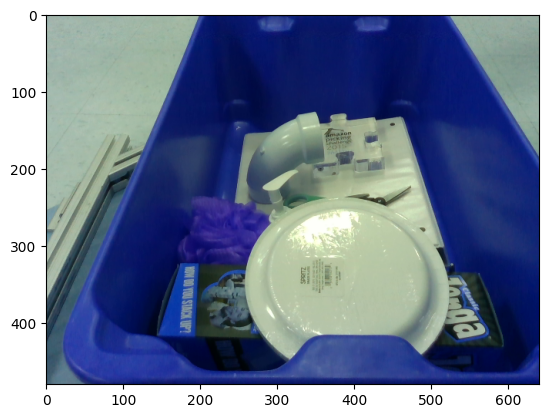

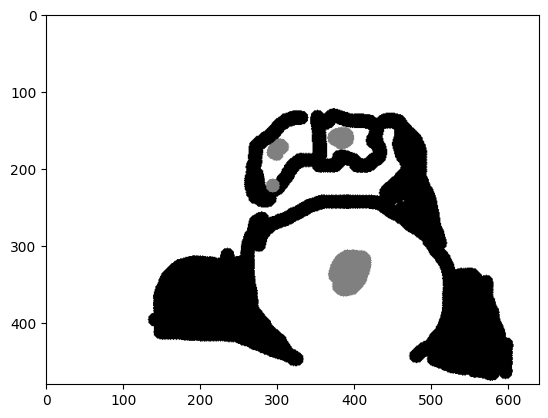

In [3]:
# Load dataset and create dataloader
dataset = SegNetDataset(root_dir='data', transform=tf.ToTensor())


# Create a test, train, validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=4, shuffle=True)


# Show sample image and mask
for i, (images, masks) in enumerate(train_loader):
    print(images.shape)
    print(masks.shape)
    # Show first image and mask
    plt.imshow(images[0].permute(1, 2, 0))
    plt.show()
    plt.imshow(masks[0].permute(1, 2, 0))
    plt.show()
    break


## Define the UNet model

In [17]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model
model = UNet(in_channels=3, out_channels=3)
model.to(device)

# Define loss function
criterion = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# Define training function
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device):
    for epoch in range(epochs):
        # Set model to train mode
        model.train()
        train_loss = 0
        for i, (images, masks) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device)
            # Forward pass
            outputs = model(images)

            # print("masks dim:", masks.shape)
            # print("outputs dim:", outputs.shape)

            loss = criterion(outputs, masks)
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        # Set model to eval mode
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for i, (images, masks) in enumerate(val_loader):
                images = images.to(device)
                masks = masks.to(device)
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        # Print loss
        print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}')
        # Update learning rate
        scheduler.step(val_loss)
        # Save model
        torch.save(model.state_dict(), 'model.pth')

# Train model
train(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=10, device=device)

# Load model
model.load_state_dict(torch.load('model.pth'))

# Set model to eval mode
model.eval()

# Define test function
def test(model, test_loader, device):
    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            images = images.to(device)
            masks = masks.to(device)
            # Forward pass
            outputs = model(images)
            # Show image and mask
            plt.imshow(images[0].permute(1, 2, 0))
            plt.show()
            plt.imshow(masks[0].permute(1, 2, 0))
            plt.show()
            # Show output
            plt.imshow(outputs[0].permute(1, 2, 0))
            plt.show()
            break
    
# Test model
test(model, test_loader, device)


RuntimeError: CUDA out of memory. Tried to allocate 38.00 MiB (GPU 0; 3.00 GiB total capacity; 2.56 GiB already allocated; 0 bytes free; 2.57 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF